In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import scipy
import os
from itertools import permutations
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve
import difflib
from moviepy.editor import *
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

c:\Users\Jorge\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Processing functions

In [2]:
def open_sessions(path):
    with open(path, 'rb') as handle:
        feats = pickle.load(handle)
    return feats

def select_features(feats, feats_list):
    
    for feat_day in feats.keys():
        feats[feat_day] = feats[feat_day][feats_list]
        
    return feats

def map_density(X_embedded, bins=50, sigma=2.5, percentile=30, cm = 'nipy_spectral', watershed_line=True, wt=0):

    # Find local maxima as "seeds" for the watershed transform
    all_map_density, xe, ye = heatmap(X_embedded, bins=bins, sigma=sigma)
    density_cutoff = np.percentile(all_map_density, percentile)
    density_mask = all_map_density > density_cutoff
    local_maxes = peak_local_max(all_map_density, indices=False)
    local_maxes[np.logical_not(density_mask)] = False
    markers, n_peaks = scipy.ndimage.label(local_maxes)

    # Compute watershed transform
    
    labeled_map = watershed(-all_map_density, markers, watershed_line=False)
    labeled_map = labeled_map.astype('float64')
    
    labeled_map_viz = watershed(-all_map_density, markers, watershed_line=watershed_line)
    labeled_map_viz = labeled_map_viz.astype('float64')

    viz = all_map_density
    viz[labeled_map_viz==0]=wt
    plt.figure(figsize=(10,10))
    plt.imshow(all_map_density.T, cmap=cm,origin='lower')
    
    plt.axis('off')
    plt.show()
    
    ###
    
    plt.figure(figsize=(10,10))
    plt.imshow(labeled_map.T, cmap='rainbow',origin='lower')
    plt.axis('off')

    for i in np.unique(labeled_map.flatten()):
        x=np.mean(np.where(labeled_map==i)[0])
        y=np.mean(np.where(labeled_map==i)[1])
        plt.text(x,y,int(i),size=20)

    plt.show()
    
    return labeled_map, all_map_density, xe, ye, local_maxes

def heatmap(data, axlims=None, bins=100, normed=True, sigma=0.0):
    
    # Initial histogram
    heatmap, xedges, yedges = np.histogram2d(data[:,0], data[:, 1], bins=bins, range=axlims, normed=normed)
    
    # Convolve with Gaussian
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    
    return heatmap, xedges, yedges

def embedding_labels(embeddings, labeled_map, xe, ye, bins=100):

    labels = {}

    map_shape=(bins,bins)
    xmin=min(xe)
    xmax=max(xe)
    ymin=min(ye)
    ymax=max(ye)

    for k, e in embeddings.items():
        
        def to_coords(xy):
            
            x = (xy[0] - xmin) / (xmax - xmin) * map_shape[0]
            y = (xy[1] - ymin) / (ymax - ymin) * map_shape[1]
            if x >= map_shape[0]:
                x = map_shape[0]-1
            if y >= map_shape[1]:
                y = map_shape[1]-1
            if x < 0:
                x=0
            if y < 0:
                y=0
            return int(x), int(y)

        labels[k] = np.array([labeled_map[to_coords(point)] for point in e])
        
    return labels

### Import data

In [3]:

direct = 'E:\\data\\embeddings_041824\\'
file = 'Feats3_100k_samples_UMAP_01mindist_50neighbors_embeddings.pickle'

[x for x in os.listdir(direct) if '.pickle' in x]

['Feats5_100k_samples_UMAP_01mindist_50neighbors_embeddings.pickle',
 'Feats5_100k_samples_UMAP_01mindist_50neighbors_labels.pickle',
 'Feats3_100k_samples_UMAP_01mindist_50neighbors_labels.pickle',
 'Feats3_100k_samples_UMAP_01mindist_50neighbors_embeddings.pickle']

In [4]:
# import pickle
data = open_sessions(direct + file)

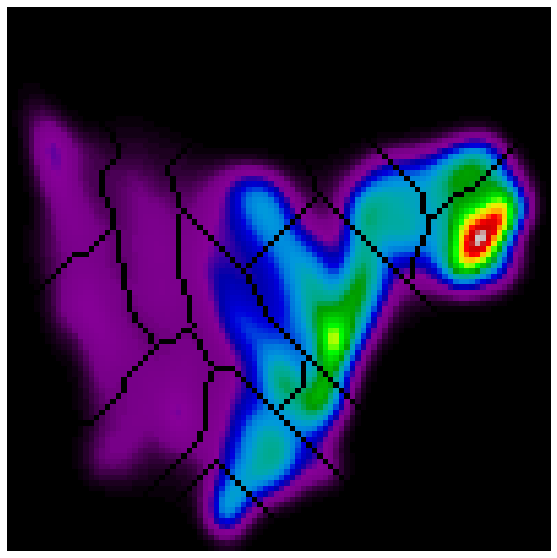

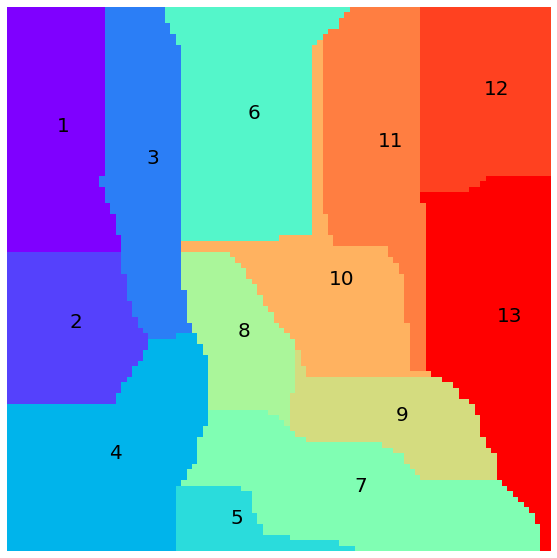

In [5]:
# concatenate all embeddings
final_embs = []
for key in data.keys():
    final_embs.append(data[key])
final_embs = np.row_stack(final_embs)

# run watershed on concatenated embeddings

### for analysis, feats 3 bins=100, percentile=74.4, sigma=2
labeled_map, density, xe, ye, _ = map_density(final_embs, bins=100, percentile=74.4, sigma=2) 
labels = embedding_labels(data, labeled_map, xe, ye, bins=100)

# derive final label set
final_labels = []
for key in labels.keys():
    final_labels.append(labels[key])
final_labels = np.concatenate(final_labels)

(-0.5, 99.5, -0.5, 99.5)

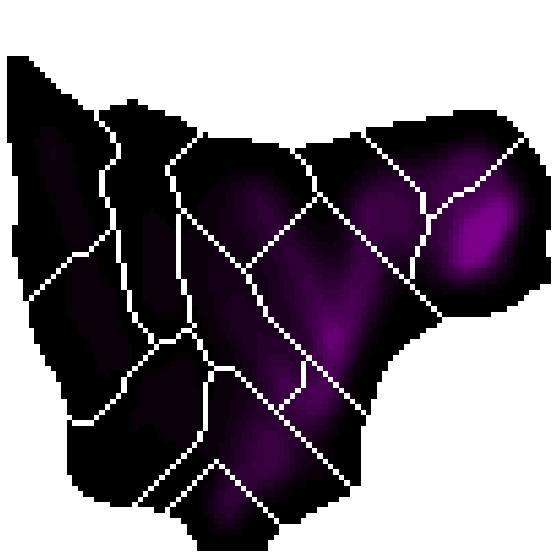

In [6]:
masked_data = density.T
masked_data = np.ma.masked_where(masked_data <= 6.976043926923529e-05, masked_data)
plt.figure(figsize=(10,10))
plt.imshow(masked_data, origin='lower', cmap='nipy_spectral', vmax=1) # vmax = 1 for outlines
plt.axis('off')
# plt.savefig('C:\\Users\\Jorge\\Desktop\\emb.png', dpi=300)

In [7]:
from skimage import measure

def compute_edges(mask):
    """
    Compute the edges around the True values of a binary mask.

    Parameters:
    - mask (2D boolean array): A binary mask where True indicates a valid element and False indicates an invalid element.

    Returns:
    - edges (list of arrays): A list of 2D arrays, where each array contains the (x, y) coordinates of the edges around the True values of the mask.
    """
    
    mask = mask.T
    
    # Find the contours of the mask
    contours = measure.find_contours(mask.astype(int), 0.99)

    # Convert the contours to edges
    edges = []
    for contour in contours:
        x, y = contour[:, 1], contour[:, 0]
        edges.append(list(zip(x, y)))

    return edges

# Compute the edges around the True values of the mask
edges = compute_edges(masked_data.mask)


In [8]:
			   # DISTANCES
feats_list1 =  ['proximity', 'resident2intruder head-head', 'resident2intruder head-tti', 'intruder2resident head-tti',
			   # SOCIAL ORIENTATIONS
			   'resident2intruder head2centroid angle', 'intruder2resident head2centroid angle',
			   # SPEEDS
			   'resident centroid roc 100 ms', 'intruder centroid roc 100 ms', 'resident head roc 100 ms', 'intruder head roc 100 ms',
			   # POSTURAL INFORMATION
			   'resident centroid2nose angle', 'intruder centroid2nose angle', 'resident tti2head', 'intruder tti2head']

			   # DISTANCES
feats_list2 =  ['proximity', 'resident2intruder head-head', 'resident2intruder head-tti', 'intruder2resident head-tti',
			   # SOCIAL ORIENTATIONS
			   'resident2intruder head2centroid angle', 'intruder2resident head2centroid angle',
			   # SPEEDS
			   'resident centroid roc 100 ms', 'intruder centroid roc 100 ms', 'resident head roc 100 ms', 'intruder head roc 100 ms',
			   'resident centroid roc 100 ms sum across lags', 'intruder centroid roc 100 ms sum across lags', 'resident head roc 100 ms sum across lags', 'intruder head roc 100 ms sum across lags',
			   # IoU
			   'ious',
			   # POSTURAL INFORMATION
			   'resident centroid2nose angle', 'intruder centroid2nose angle', 'resident tti2head', 'intruder tti2head']

			   # DISTANCES
feats_list3 =  ['proximity', 'resident2intruder head-head', 'resident2intruder head-tti', 'intruder2resident head-tti',
			   # SOCIAL ORIENTATIONS
			   'resident2intruder head2centroid angle', 'intruder2resident head2centroid angle',
			   # SPEEDS
			   'resident centroid roc 100 ms', 'intruder centroid roc 100 ms', 'resident head roc 100 ms', 'intruder head roc 100 ms',
			   'resident centroid roc 100 ms sum across lags', 'intruder centroid roc 100 ms sum across lags', 'resident head roc 100 ms sum across lags', 'intruder head roc 100 ms sum across lags',
			   # IoU and pixel change
			   'ious',
			   # POSTURAL INFORMATION
			   'resident centroid2nose angle', 'intruder centroid2nose angle', 'resident tti2head', 'intruder tti2head']

			   # DISTANCES
feats_list4 =  ['proximity', 'resident2intruder head-head', 'resident2intruder head-tti', 'intruder2resident head-tti',
			   # SOCIAL ORIENTATIONS
			   'resident2intruder head2centroid angle', 'intruder2resident head2centroid angle',
			   # SPEEDS
			   'resident centroid roc 100 ms', 'intruder centroid roc 100 ms', 'resident head roc 100 ms', 'intruder head roc 100 ms', 'proximity roc 100 ms',
			   'resident centroid roc 100 ms sum across lags', 'intruder centroid roc 100 ms sum across lags', 'resident head roc 100 ms sum across lags', 'intruder head roc 100 ms sum across lags',
			   'proximity roc 100 ms sum across lags',
			   # IoU and pixel change
			   'ious',
			   # POSTURAL INFORMATION
			   'resident centroid2nose angle', 'intruder centroid2nose angle', 'resident tti2head', 'intruder tti2head']

			   # DISTANCES
feats_list5 =  ['proximity', 'proximity median across lags', 'resident2intruder head-head', 'resident2intruder head-head median across lags', 'resident2intruder head-tti', 'intruder2resident head-tti',
			   # SOCIAL ORIENTATIONS
			   'resident2intruder head2centroid angle', 'intruder2resident head2centroid angle',
			   # SPEEDS
			   'resident centroid roc 100 ms', 'intruder centroid roc 100 ms', 'resident head roc 100 ms', 'intruder head roc 100 ms', 'proximity roc 100 ms',
			   'resident centroid roc 100 ms sum across lags', 'intruder centroid roc 100 ms sum across lags', 'resident head roc 100 ms sum across lags', 'intruder head roc 100 ms sum across lags',
			   'proximity roc 100 ms sum across lags',
			   # IoU and pixel change
			   'ious',
			   # POSTURAL INFORMATION
			   'resident centroid2nose angle', 'intruder centroid2nose angle', 'resident tti2head', 'intruder tti2head']


feats_list = list(set(feats_list1 + feats_list2 + feats_list3 + feats_list4 + feats_list5))
feats_list.sort()
feats_list = np.asarray(feats_list)

from tqdm import tqdm

features = {}
implanted_list = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '29L', '30R2', '30B', '91R2', '30L', '87R2', '87L', '87B', '87L2', '86L', '86L2']
feats_path = "E:\\data\\processed_features_020924\\"
feat_pickles = np.sort([x for x in os.listdir(feats_path) if 'zscored' in x])
for session in tqdm(np.sort(feat_pickles)):
    if any(imp in session for imp in implanted_list):
        n = 4
    else:
        n = 3
    z = pd.read_parquet(feats_path + session, columns=feats_list)
    features['_'.join(session.split('_')[:n])] = z

  0%|          | 0/504 [00:00<?, ?it/s]

100%|██████████| 504/504 [01:57<00:00,  4.29it/s]


### Functions for creating heatmaps

In [9]:
def heatmapdiff(data,data2, axlims=None, bins=100, normed=True, sigma=0.0,subtract=0):
    
    from scipy.ndimage.filters import gaussian_filter
    # Initial histogram
    heatmap, xedges, yedges = np.histogram2d(data[:,0], data[:, 1],
            bins=bins, range=axlims, normed=normed)
    heatmap2, xedges, yedges = np.histogram2d(data2[:,0], data2[:, 1],
            bins=bins, range=axlims, normed=normed)
    
    # Convolve with Gaussian
    heatmap = gaussian_filter((heatmap+0.000001)/(heatmap2+0.000001)-subtract, sigma=sigma)
    
    return heatmap,xedges,yedges

def heatmapmean(data, z, xe ,ye, normed=True, sigma=0.0, bins=100):
    from scipy.ndimage.filters import gaussian_filter
    heatmap, xedges, yedges = np.histogram2d(data[:,0], data[:, 1],
            bins=(xe,ye))
    xbins=np.digitize(data[:,0],xe)
    ybins=np.digitize(data[:,1],ye)
    df=pd.DataFrame({'x':xbins,'y':ybins,'n':z})

    df=df.groupby(['x','y']).mean()
    df=df.add_suffix('').reset_index()
    
    meanmap=np.zeros([bins,bins])
    for x,y,n in df.values:
        if x>=bins or y>=bins:
            continue
        meanmap[int(x),int(y)]=n
    return gaussian_filter(meanmap,sigma=sigma)

def heatmap(data, axlims=None, bins=100, normed=True, sigma=0.0):
    from scipy.ndimage.filters import gaussian_filter
    # Initial histogram
    heatmap, xedges, yedges = np.histogram2d(data[:,0], data[:, 1],
            bins=bins, range=axlims, normed=normed)
    # Convolve with Gaussian
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    return heatmap,xedges,yedges

## Map neural activity to embedding 

In [10]:
# inits jic

days = ['day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7', 'day8', 'day9']
ds = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9']
agg_cohort1 = ['3095', '3096', '3097']
agg_cohort2 = ['4013', '4014', '4015', '4016']
agg_cohort3 = ['30R2', '29L', '30L', '30B', '91R2']
obs_cohort1 = ['29L', '30R2']
obs_cohort2 = ['87L2', '86L']
non_cohort1 = ['87R2', '87B', '87L', '86L2']
cohorts = np.concatenate([agg_cohort1, agg_cohort2, agg_cohort3, obs_cohort1, obs_cohort2, non_cohort1])

def reshape_vector(v1, v2, n_clusters=9):
    if len(v1) < len(v2):
        # If v1 is smaller, truncate v2
        return v2[:len(v1)]
    else:
        # If v1 is larger, pad v2 with random numbers
        if n_clusters>2:
            padding = np.random.randint(1, n_clusters+1, len(v1) - len(v2))
        else:
            padding = np.random.randint(0, 2, len(v1) - len(v2))
        return np.concatenate((v2, padding))
    
def check_strings_in_text(text, string_list):
    return any(s in text for s in string_list)

In [22]:
import _pickle as cPickle
import numpy as np
save_path = 'E:\\data\\embedding_viz_042524_bsc\\'
full_data = pd.read_pickle('C:\\Users\\Jorge\\Documents\\PythonScripts\\fully_labeled_traces_feats3_042224_baseline_corrected.pickle')
np.random.seed(123401)

for i, key in enumerate(np.array(list(full_data.keys()))):
    
    print('Processing %s' % key)
            
    # behavior data
    try:
        f_data = features[key]
        b = f_data['proximity'].values
        embedding = data[key]
    except KeyError:
        print('No behavior data found for %s' % key) # check if behavior data is available
        if '_toy_' in key and check_strings_in_text(key, non_cohort1) and 'd9' not in key:
            print('Detected toy session, using random behavior data')
            k = list(features.keys())[np.random.randint(0, len(features.keys()))]
            while 'd9' in k:
                k = list(features.keys())[np.random.randint(0, len(features.keys()))]
            b = features[k]['proximity'].values
            embedding = data[k]
            if len(b) > len(full_data[key]):
                b = b[:len(full_data[key])]
                embedding = embedding[:len(full_data[key])]
            else:
                b = np.concatenate([b, b[:(len(b) - len(full_data[key])) * -1]])
                embedding = np.concatenate([embedding, embedding[:(len(embedding) - len(full_data[key])) * -1]])
        else:
            continue
            
    print('Mapping neural data to embedding...')

    for region in [x for x in full_data[key].columns if 'labels' not in x]:
        
        signal = full_data[key][region]
        
        if np.isnan(signal).any():
            continue

        nrows = np.arange(len(xe)).astype(int)

        xy2reg = {(i, j): [] for i, j in permutations(nrows, 2)}

        for i in range(len(xe)):
            xy2reg[(i, i)] = []

        sigma = 4.

        mean_reg = heatmapmean(embedding, signal, xe=xe, ye=ye, sigma=sigma)
        with open(r'%s%s_mean_%s_activity.pickle' % (save_path, key, region), "wb") as output_file:
            cPickle.dump(mean_reg, output_file)

    print('Finished!')
            

Processing 29L_d1_balbc_t1
Mapping neural data to embedding...
Finished!
Processing 29L_d1_balbc_t2
Mapping neural data to embedding...
Finished!
Processing 29L_d1_balbc_t3
Mapping neural data to embedding...
Finished!
Processing 29L_d1_obs_t1
Mapping neural data to embedding...
Finished!
Processing 29L_d1_obs_t2
Mapping neural data to embedding...
Finished!
Processing 29L_d1_obs_t3
Mapping neural data to embedding...
Finished!
Processing 29L_d2_balbc_t1
Mapping neural data to embedding...
Finished!
Processing 29L_d2_balbc_t2
Mapping neural data to embedding...
Finished!
Processing 29L_d2_balbc_t3
Mapping neural data to embedding...
Finished!
Processing 29L_d2_obs_t1
Mapping neural data to embedding...
Finished!
Processing 29L_d2_obs_t2
Mapping neural data to embedding...
Finished!
Processing 29L_d2_obs_t3
Mapping neural data to embedding...
Finished!
Processing 29L_d3_balbc_t1
Mapping neural data to embedding...
Finished!
Processing 29L_d3_balbc_t2
Mapping neural data to embedding...


In [16]:
def plot_edges(edges, axis):
    for e in edges:
        x, y = zip(*e)
        grid[axis].plot(y, x, color='black')

In [17]:
from matplotlib import colors
from mpl_toolkits.axes_grid1 import ImageGrid

Generate normal activity maps

In [18]:
region_order = ['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)',
       'BNST (E)', 'BNST (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)',
       'VMH (E)', 'VMH (I)', 'PAG (E)', 'PAG (I)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)',
       'PA (E)', 'PA (I)', 'NAc (DA)'] # populations
indices = {val: idx for idx, val in enumerate(region_order)} # dictionary with IDs for remapping

KeyboardInterrupt: 

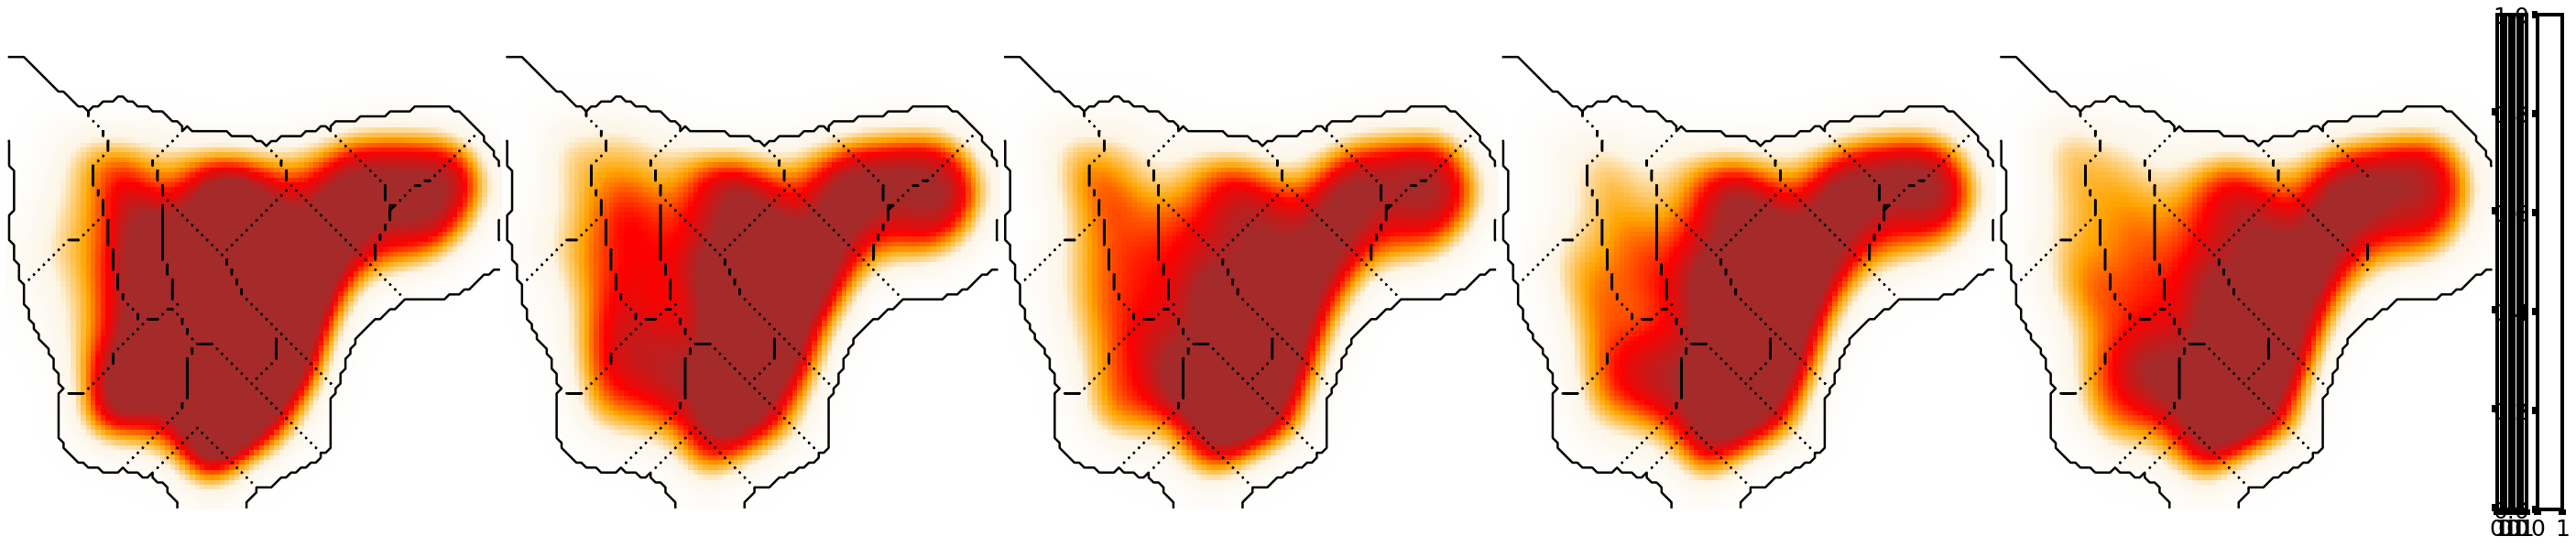

In [23]:
from mpl_toolkits.axes_grid1 import ImageGrid

sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

agg_animals = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '91R2', '30L', '30B']
obs_animals = ['29L', '30R2', '86L', '87L2']
non_animals = ['87R2', '87L', '86L2', '87B']
all_animals = np.concatenate([agg_animals, obs_animals, non_animals])
save_path = 'E:\\data\\embedding_viz_042524_bsc\\'
fig_path = 'C:\\Users\\Jorge\\Documents\\PythonScripts\\embedding_figs_042524_bsc\\'
groups = ['aggro', 'obs', 'non']


for roi in region_order:
    pdfs = [save_path + x for x in np.sort(os.listdir(save_path)) if '.pickle' in x]
    pdfs = [pdf for pdf in pdfs if roi in pdf]
    all_paths = []

    for a, animal_ID in enumerate(all_animals): # switch exp vs obs
        if a < 10:
            stim1 = 'balbc'
            stim2 = '_mCD1'
        elif a < 14:
            stim1 = 'obs'
            stim2 = 'OBSmCD1'
        else:
            stim1 = 'toy'
            stim2 = 'toyCD1'
        pdf_paths =  np.sort([x for x in pdfs if animal_ID in x])
        pdf_paths = [x for x in pdf_paths if stim1 in x or stim2 in x]
        all_paths.append(pdf_paths)

    pdf1, pdf2, pdf3, pdf4, pdf5, pdf6, pdf7, pdf8, pdf9, pdf10, pdf11, pdf12, pdf13, pdf14, pdf15, pdf16, pdf17, pdf18 = all_paths
    non_empty_paths = [pdf1, pdf2, pdf3, pdf4, pdf5, pdf6, pdf7, pdf8, pdf9, pdf10, pdf11, pdf12, pdf13, pdf14, pdf15, pdf16, pdf17, pdf18]

    for exp_group in np.arange(3):

        if exp_group == 0: # adjust n and k for each group
            n = 10
            k = 27
            paths2map = non_empty_paths[:10]
        elif exp_group == 1:
            n= 4
            k = 27
            paths2map = non_empty_paths[10:14]
        else:
            n = 4
            k = 27
            paths2map = non_empty_paths[14:]

        all_sessions = np.zeros((100, 100, n, k))
        all_sessions[:] = np.nan

        for i in range(k):
            for j in range(len(paths2map)):
                try:
                    all_sessions[:, :, j, i] = pd.read_pickle(paths2map[j][i]).T
                except IndexError:
                    continue

        all_sessions = np.nanmean(all_sessions, axis=2)
        d1 = np.nanmean(all_sessions[:, :, 0:3], axis=2)
        d2 = np.nanmean(all_sessions[:, :, 3:6], axis=2)
        d3 = np.nanmean(all_sessions[:, :, 6:9], axis=2)
        d4 = np.nanmean(all_sessions[:, :, 9:12], axis=2)
        d5 = np.nanmean(all_sessions[:, :, 12:15], axis=2)
        d6 = np.nanmean(all_sessions[:, :, 15:18], axis=2)
        d7 = np.nanmean(all_sessions[:, :, 18:21], axis=2)
        d8 = np.nanmean(all_sessions[:, :, 21:24], axis=2)
        d9 = np.nanmean(all_sessions[:, :, 24:27], axis=2)
        full_avg = np.nanmean(all_sessions, axis=2)     
        baseline = np.mean([d1.mean(), d2.mean(), d3.mean(), d4.mean(), d5.mean(), d6.mean(), d7.mean(), d8.mean(), d9.mean()])


        vmin = 0
        vmax = 0.75
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        cmap = colors.LinearSegmentedColormap.from_list("", ["white","oldlace", "orange","red", "brown"])

        fig = plt.figure(figsize=(50,10))
        grid = ImageGrid(fig, 111,
                        nrows_ncols = (1,9),
                        axes_pad = 0.05,
                        cbar_location = "right",
                        cbar_mode="single",
                        cbar_size="5%",
                        cbar_pad=0.17
                        )

        # if exp_group == 2:
        #     d9 = d1.copy()
        #     d1, d2, d3, d4, d5, d6, d7, d8 = [np.zeros((100,100)) for x in np.arange(8)]

        im = grid[0].imshow(d1, origin='lower', cmap=cmap, norm=norm)
        grid[0].axis('off')
        plot_edges(edges, axis=0)

        grid[1].imshow(d2, origin='lower', cmap=cmap, norm=norm)
        grid[1].axis('off')
        plot_edges(edges, axis=1)

        grid[2].imshow(d3, origin='lower', cmap=cmap, norm=norm)
        grid[2].axis('off')
        plot_edges(edges, axis=2)

        grid[3].imshow(d4, origin='lower', cmap=cmap, norm=norm)
        grid[3].axis('off')
        plot_edges(edges, axis=3)

        grid[4].imshow(d5, origin='lower', cmap=cmap, norm=norm)
        grid[4].axis('off')
        plot_edges(edges, axis=4)

        grid[5].imshow(d6, origin='lower', cmap=cmap, norm=norm)
        grid[5].axis('off')
        plot_edges(edges, axis=5)

        grid[6].imshow(d7, origin='lower', cmap=cmap, norm=norm)
        grid[6].axis('off')
        plot_edges(edges, axis=6)

        grid[7].imshow(d8, origin='lower', cmap=cmap, norm=norm)
        grid[7].axis('off')
        plot_edges(edges, axis=7)

        grid[8].imshow(d9, origin='lower', cmap=cmap, norm=norm)
        grid[8].axis('off')
        plot_edges(edges, axis=8)

        grid[8].cax.colorbar(im)
        cax = grid.cbar_axes[0]
        axis = cax.axis[cax.orientation]
        axis.label.set_rotation(270)
        
        fig.savefig(fig_path + roi + '_' + groups[exp_group] + '.png', dpi=50, bbox_inches='tight')
        plt.close()

Generate E-I maps

In [25]:
from mpl_toolkits.axes_grid1 import ImageGrid

sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

agg_animals = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '91R2', '30L', '30B']
obs_animals = ['29L', '30R2', '86L', '87L2']
non_animals = ['87R2', '87L', '86L2', '87B']
rois_E = ['PrL (E)', 'vLS (E)', 'POA (E)', 'BNST (E)', 'AH (E)', 'MeA (E)', 'VMH (E)', 'PMv (E)', 'LHb (E)', 'PA (E)', 'PAG (E)']
rois_I = ['PrL (I)', 'vLS (I)', 'POA (I)', 'BNST (I)', 'AH (I)', 'MeA (I)', 'VMH (I)', 'PMv (I)', 'LHb (I)', 'PA (I)', 'PAG (I)']
all_animals = np.concatenate([agg_animals, obs_animals, non_animals])
save_path = 'E:\\data\\embedding_viz_042524_bsc\\'
fig_path = 'C:\\Users\\Jorge\\Documents\\PythonScripts\\embedding_figs_042524_bsc\\'
groups = ['aggro', 'obs', 'non']


for i, (roi_E, roi_I) in enumerate(zip(rois_E, rois_I)):
    pdfs = [save_path + x for x in np.sort(os.listdir(save_path)) if '.pickle' in x]
    pdfs_E = [pdf for pdf in pdfs if roi_E in pdf]
    pdfs_I = [pdf for pdf in pdfs if roi_I in pdf]
    all_paths_E = []
    all_paths_I = []

    for a, animal_ID in enumerate(all_animals): # switch exp vs obs
        if a < 10:
            stim1 = 'balbc'
            stim2 = '_mCD1'
        elif a < 14:
            stim1 = 'obs'
            stim2 = 'OBSmCD1'
        else:
            stim1 = 'toy'
            stim2 = 'toyCD1'

        print(animal_ID, stim1, stim2)
        pdf_E_paths =  np.sort([x for x in pdfs_E if animal_ID in x])
        pdf_E_paths = [x for x in pdf_E_paths if stim1 in x or stim2 in x]
        all_paths_E.append(pdf_E_paths)

        pdf_I_paths =  np.sort([x for x in pdfs_I if animal_ID in x])
        pdf_I_paths = [x for x in pdf_I_paths if stim1 in x or stim2 in x]
        all_paths_I.append(pdf_I_paths)

    pdf1_E, pdf2_E, pdf3_E, pdf4_E, pdf5_E, pdf6_E, pdf7_E, pdf8_E, pdf9_E, pdf10_E, pdf11_E, pdf12_E, pdf13_E, pdf14_E, pdf15_E, pdf16_E, pdf17_E, pdf18_E = all_paths_E
    non_empty_paths_E = [pdf1_E, pdf2_E, pdf3_E, pdf4_E, pdf5_E, pdf6_E, pdf7_E, pdf8_E, pdf9_E, pdf10_E, pdf11_E, pdf12_E, pdf13_E, pdf14_E, pdf15_E, pdf16_E, pdf17_E, pdf18_E]

    pdf1_I, pdf2_I, pdf3_I, pdf4_I, pdf5_I, pdf6_I, pdf7_I, pdf8_I, pdf9_I, pdf10_I, pdf11_I, pdf12_I, pdf13_I, pdf14_I, pdf15_I, pdf16_I, pdf17_I, pdf18_I = all_paths_I
    non_empty_paths_I = [pdf1_I, pdf2_I, pdf3_I, pdf4_I, pdf5, pdf6_I, pdf7_I, pdf8_I, pdf9_I, pdf10_I, pdf11_I, pdf12_I, pdf13_I, pdf14_I, pdf15_I, pdf16_I, pdf17_I, pdf18_I]

    for exp_group in np.arange(3):

        if exp_group == 0:
            n = 10
            k = 27
            paths2map_E = non_empty_paths_E[:10]
            paths2map_I = non_empty_paths_I[:10]
        elif exp_group == 1:
            n= 4
            k = 27
            paths2map_E = non_empty_paths_E[10:14]
            paths2map_I = non_empty_paths_I[10:14]
        else:
            n = 4
            k = 27
            paths2map_E = non_empty_paths_E[14:]
            paths2map_I = non_empty_paths_I[14:]

        all_sessions_E = np.zeros((100, 100, n, k))
        all_sessions_E[:] = np.nan

        all_sessions_I = np.zeros((100, 100, n, k))
        all_sessions_I[:] = np.nan

        for i in range(k):
            for j in range(len(paths2map_E)):
                try:
                    all_sessions_E[:, :, j, i] = pd.read_pickle(paths2map_E[j][i]).T
                    all_sessions_I[:, :, j, i] = pd.read_pickle(paths2map_I[j][i]).T
                except IndexError:
                    continue

        all_sessions_E = np.nanmean(all_sessions_E, axis=2)
        all_sessions_I = np.nanmean(all_sessions_I, axis=2)
        d1 = np.nanmean(all_sessions_E[:, :, 0:3], axis=2) - np.nanmean(all_sessions_I[:, :, 0:3], axis=2)
        d2 = np.nanmean(all_sessions_E[:, :, 3:6], axis=2) - np.nanmean(all_sessions_I[:, :, 3:6], axis=2)
        d3 = np.nanmean(all_sessions_E[:, :, 6:9], axis=2) - np.nanmean(all_sessions_I[:, :, 6:9], axis=2)
        d4 = np.nanmean(all_sessions_E[:, :, 9:12], axis=2) - np.nanmean(all_sessions_I[:, :, 9:12], axis=2)
        d5 = np.nanmean(all_sessions_E[:, :, 12:15], axis=2) - np.nanmean(all_sessions_I[:, :, 12:15], axis=2)
        d6 = np.nanmean(all_sessions_E[:, :, 15:18], axis=2) - np.nanmean(all_sessions_I[:, :, 15:18], axis=2)
        d7 = np.nanmean(all_sessions_E[:, :, 18:21], axis=2) - np.nanmean(all_sessions_I[:, :, 18:21], axis=2)
        d8 = np.nanmean(all_sessions_E[:, :, 21:24], axis=2) - np.nanmean(all_sessions_I[:, :, 21:24], axis=2)
        d9 = np.nanmean(all_sessions_E[:, :, 24:27], axis=2) - np.nanmean(all_sessions_I[:, :, 24:27], axis=2)   
        baseline = np.mean([d1.mean(), d2.mean(), d3.mean(), d4.mean(), d5.mean(), d6.mean(), d7.mean(), d8.mean(), d9.mean()])


        norm = colors.TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
        cmap = 'seismic'

        fig = plt.figure(figsize=(50,10))
        grid = ImageGrid(fig, 111,
                        nrows_ncols = (1,9),
                        axes_pad = 0.05,
                        cbar_location = "right",
                        cbar_mode="single",
                        cbar_size="5%",
                        cbar_pad=0.17
                        )

        im = grid[0].imshow(d1, origin='lower', cmap=cmap, norm=norm)
        grid[0].axis('off')
        plot_edges(edges, axis=0)

        grid[1].imshow(d2, origin='lower', cmap=cmap, norm=norm)
        grid[1].axis('off')
        plot_edges(edges, axis=1)

        grid[2].imshow(d3, origin='lower', cmap=cmap, norm=norm)
        grid[2].axis('off')
        plot_edges(edges, axis=2)

        grid[3].imshow(d4, origin='lower', cmap=cmap, norm=norm)
        grid[3].axis('off')
        plot_edges(edges, axis=3)

        grid[4].imshow(d5, origin='lower', cmap=cmap, norm=norm)
        grid[4].axis('off')
        plot_edges(edges, axis=4)

        grid[5].imshow(d6, origin='lower', cmap=cmap, norm=norm)
        grid[5].axis('off')
        plot_edges(edges, axis=5)

        grid[6].imshow(d7, origin='lower', cmap=cmap, norm=norm)
        grid[6].axis('off')
        plot_edges(edges, axis=6)

        grid[7].imshow(d8, origin='lower', cmap=cmap, norm=norm)
        grid[7].axis('off')
        plot_edges(edges, axis=7)

        grid[8].imshow(d9, origin='lower', cmap=cmap, norm=norm)
        grid[8].axis('off')
        plot_edges(edges, axis=8)

        grid[8].cax.colorbar(im)
        cax = grid.cbar_axes[0]
        axis = cax.axis[cax.orientation]
        axis.label.set_rotation(270)
        
        fig.savefig(fig_path + roi_E.replace(' (E)', '') + '_EI_' + groups[exp_group] + '.png', dpi=300, bbox_inches='tight')
        plt.close()

3095 balbc _mCD1
3096 balbc _mCD1
3097 balbc _mCD1
4013 balbc _mCD1
4014 balbc _mCD1
4015 balbc _mCD1
4016 balbc _mCD1
91R2 balbc _mCD1
30L balbc _mCD1
30B balbc _mCD1
29L obs OBSmCD1
30R2 obs OBSmCD1
86L obs OBSmCD1
87L2 obs OBSmCD1
87R2 toy toyCD1
87L toy toyCD1
86L2 toy toyCD1
87B toy toyCD1
3095 balbc _mCD1
3096 balbc _mCD1
3097 balbc _mCD1
4013 balbc _mCD1
4014 balbc _mCD1
4015 balbc _mCD1
4016 balbc _mCD1
91R2 balbc _mCD1
30L balbc _mCD1
30B balbc _mCD1
29L obs OBSmCD1
30R2 obs OBSmCD1
86L obs OBSmCD1
87L2 obs OBSmCD1
87R2 toy toyCD1
87L toy toyCD1
86L2 toy toyCD1
87B toy toyCD1
3095 balbc _mCD1
3096 balbc _mCD1
3097 balbc _mCD1
4013 balbc _mCD1
4014 balbc _mCD1
4015 balbc _mCD1
4016 balbc _mCD1
91R2 balbc _mCD1
30L balbc _mCD1
30B balbc _mCD1
29L obs OBSmCD1
30R2 obs OBSmCD1
86L obs OBSmCD1
87L2 obs OBSmCD1
87R2 toy toyCD1
87L toy toyCD1
86L2 toy toyCD1
87B toy toyCD1
3095 balbc _mCD1
3096 balbc _mCD1
3097 balbc _mCD1
4013 balbc _mCD1
4014 balbc _mCD1
4015 balbc _mCD1
4016 balbc

In [32]:
from mpl_toolkits.axes_grid1 import ImageGrid

sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

agg_animals = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '91R2', '30R2', '30L']
obs_animals = ['29L', '30R2', '87L2', '86L']
non_animals = ['87R2', '87B', '87L', '86L2']
all_animals = np.concatenate([agg_animals, obs_animals, non_animals])
save_path = 'E:\\data\\embedding_viz_042524_bsc\\'

for i, (roi_E, roi_I) in enumerate(zip(rois_E, rois_I)):

    pdfs = [save_path + x for x in np.sort(os.listdir(save_path)) if '.pickle' in x]

    obs_pdfs = [x for x in pdfs if 'OBSmCD1' in x] # if obs
    obs_pdfs_E = [pdf for pdf in obs_pdfs if roi_E in pdf]
    obs_pdfs_I = [pdf for pdf in obs_pdfs if roi_I in pdf]
    agg_pdfs = [x for x in pdfs if '_mCD1' in x] # if exp
    agg_pdfs_E = [pdf for pdf in agg_pdfs if roi_E in pdf]
    agg_pdfs_I = [pdf for pdf in agg_pdfs if roi_I in pdf]
    non_pdfs = [x for x in pdfs if 'toyCD1' in x] # if non
    non_pdfs_E = [pdf for pdf in non_pdfs if roi_E in pdf]
    non_pdfs_I = [pdf for pdf in non_pdfs if roi_I in pdf]

    agg_all_paths_E = []
    obs_all_paths_E = []
    non_all_paths_E = []
    agg_all_paths_I = []
    obs_all_paths_I = []
    non_all_paths_I = []

    for a, animal_ID in enumerate(all_animals):
        
        if a <= 9:
            agg_pdf_paths_E =  np.sort([x for x in agg_pdfs_E if animal_ID in x])
            agg_pdf_paths_I =  np.sort([x for x in agg_pdfs_I if animal_ID in x])
            agg_all_paths_E.append(agg_pdf_paths_E)
            agg_all_paths_I.append(agg_pdf_paths_I)
        elif a <= 13:
            obs_pdf_paths_E =  np.sort([x for x in obs_pdfs_E if animal_ID in x])
            obs_pdf_paths_I =  np.sort([x for x in obs_pdfs_I if animal_ID in x])
            obs_all_paths_E.append(obs_pdf_paths_E)
            obs_all_paths_I.append(obs_pdf_paths_I)
        else:
            non_pdf_paths_E =  np.sort([x for x in non_pdfs_E if animal_ID in x])
            non_pdf_paths_I =  np.sort([x for x in non_pdfs_I if animal_ID in x])
            non_all_paths_E.append(non_pdf_paths_E)
            non_all_paths_I.append(non_pdf_paths_I)

    agg_pdf1_E, agg_pdf2_E, agg_pdf3_E, agg_pdf4_E, agg_pdf5_E, agg_pdf6_E, agg_pdf7_E, agg_pdf8_E, agg_pdf9_E, agg_pdf10_E  = agg_all_paths_E
    agg_non_empty_paths_E = [x for x in [agg_pdf1_E, agg_pdf2_E, agg_pdf3_E, agg_pdf4_E, agg_pdf5_E, agg_pdf6_E, agg_pdf7_E, agg_pdf8_E, agg_pdf9_E, agg_pdf10_E] if x != []]
    
    agg_pdf1_I, agg_pdf2_I, agg_pdf3_I, agg_pdf4_I, agg_pdf5_I, agg_pdf6_I, agg_pdf7_I, agg_pdf8_I, agg_pdf9_I, agg_pdf10_I  = agg_all_paths_I
    agg_non_empty_paths_I = [x for x in [agg_pdf1_I, agg_pdf2_I, agg_pdf3_I, agg_pdf4_I, agg_pdf5_I, agg_pdf6_I, agg_pdf7_I, agg_pdf8_I, agg_pdf9_I, agg_pdf10_I] if x != []]

    obs_pdf1_E, obs_pdf2_E, obs_pdf3_E, obs_pdf4_E = obs_all_paths_E
    obs_non_empty_paths_E = [x for x in [obs_pdf1_E, obs_pdf2_E, obs_pdf3_E, obs_pdf4_E] if x != []]

    obs_pdf1_I, obs_pdf2_I, obs_pdf3_I, obs_pdf4_I = obs_all_paths_I
    obs_non_empty_paths_I = [x for x in [obs_pdf1_I, obs_pdf2_I, obs_pdf3_I, obs_pdf4_I] if x != []]

    non_pdf1_E, non_pdf2_E, non_pdf3_E, non_pdf4_E = non_all_paths_E
    non_non_empty_paths_E = [x for x in [non_pdf1_E, non_pdf2_E, non_pdf3_E, non_pdf4_E] if x != []]

    non_pdf1_I, non_pdf2_I, non_pdf3_I, non_pdf4_I = non_all_paths_I
    non_non_empty_paths_I = [x for x in [non_pdf1_I, non_pdf2_I, non_pdf3_I, non_pdf4_I] if x != []]

    agg_all_sessions_E = np.zeros((100, 100, len(agg_non_empty_paths_E), 3))
    agg_all_sessions_I = np.zeros((100, 100, len(agg_non_empty_paths_I), 3))
    for i in range(3):
        for j in range(len(agg_non_empty_paths_E)):
            agg_all_sessions_E[:, :, j, i] = pd.read_pickle(agg_non_empty_paths_E[j][i]).T
            agg_all_sessions_I[:, :, j, i] = pd.read_pickle(agg_non_empty_paths_I[j][i]).T

    obs_all_sessions_E = np.zeros((100, 100, len(obs_non_empty_paths_E), 3))
    obs_all_sessions_I = np.zeros((100, 100, len(obs_non_empty_paths_I), 3))
    for i in range(3):
        for j in range(len(obs_non_empty_paths_E)):
            obs_all_sessions_E[:, :, j, i] = pd.read_pickle(obs_non_empty_paths_E[j][i]).T
            obs_all_sessions_I[:, :, j, i] = pd.read_pickle(obs_non_empty_paths_I[j][i]).T

    non_all_sessions_E = np.zeros((100, 100, len(non_non_empty_paths_E), 3))
    non_all_sessions_I = np.zeros((100, 100, len(non_non_empty_paths_I), 3))
    for i in range(3):
        for j in range(len(non_non_empty_paths_E)):
            non_all_sessions_E[:, :, j, i] = pd.read_pickle(non_non_empty_paths_E[j][i]).T
            non_all_sessions_I[:, :, j, i] = pd.read_pickle(non_non_empty_paths_I[j][i]).T

    agg_all_sessions_E = np.nanmean(agg_all_sessions_E, axis=2)
    agg_all_sessions_I = np.nanmean(agg_all_sessions_I, axis=2)
    agg_avg = (np.nanmean(agg_all_sessions_E[:, :, 0:3], axis=2) - np.nanmean(agg_all_sessions_I[:, :, 0:3], axis=2))

    obs_all_sessions_E = np.nanmean(obs_all_sessions_E, axis=2)
    obs_all_sessions_I = np.nanmean(obs_all_sessions_I, axis=2)
    obs_avg = (np.nanmean(obs_all_sessions_E[:, :, 0:3], axis=2) - np.nanmean(obs_all_sessions_I[:, :, 0:3], axis=2))

    non_all_sessions_E = np.nanmean(non_all_sessions_E, axis=2)
    non_all_sessions_I = np.nanmean(non_all_sessions_I, axis=2)
    non_avg = (np.nanmean(non_all_sessions_E[:, :, 0:3], axis=2) - np.nanmean(non_all_sessions_I[:, :, 0:3], axis=2))

    # vmin = 0
    # vmax = 1.25
    norm = colors.TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)
    cmap = 'seismic'

    fig = plt.figure(figsize=(15,5))
    grid = ImageGrid(fig, 111,
                    nrows_ncols = (1,3),
                    axes_pad = 0.05,
                    )

    grid[0].imshow(agg_avg, origin='lower', cmap=cmap, norm=norm)
    grid[0].axis('off')
    # plot_edges(edges, axis=0)

    grid[1].imshow(obs_avg, origin='lower', cmap=cmap, norm=norm)
    grid[1].axis('off')
    grid[1].set_title(roi_E.replace(' (E)', ''))
    # plot_edges(edges, axis=1)

    im = grid[2].imshow(non_avg, origin='lower', cmap=cmap, norm=norm)
    grid[2].axis('off')
    # plot_edges(edges, axis=2)

    fig.colorbar(im, ax=grid, orientation='vertical', fraction=0.046)
    fig.savefig('.\\embedding_figs_042524_bsc\\%s_EI_map.svg' % (roi_E.replace(' (E)', '')), dpi=300, bbox_inches='tight')
    plt.close()